In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

### Preparación de datos

In [2]:
# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Carga el conjunto de datos MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Define el DataLoader
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Modelo Autoencoder

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, 3, stride=2, padding=1, output_padding=1),  # N, 4, 28, 28  (N,4,27,27)
            nn.Sigmoid()
)


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        # Upsampling sin usar nn.functional.interpolate
        batch_size, channels, height, width = decoded.size()
        decoded_reshaped = decoded.view(batch_size, channels, height, width)
        upsampled_decoded = F.pixel_shuffle(decoded_reshaped, 2)

        return upsampled_decoded

model = Autoencoder()

### Entrenamiento

In [4]:
# Añade ruido gaussiano a las imágenes
def add_noise(image, noise_level=0.4):
    noise = torch.randn_like(image) * noise_level
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0, 1) 

# Funciones de pérdida Peak Signal-to-Noise Ratio (PSNR)
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    psnr_value = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr_value.item()


# Optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Entrenamiento
model.train()

num_epochs = 10

for epoch in range(num_epochs):
    for (img, _) in train_loader:
        noisy_img = add_noise(img)

        recon = model(noisy_img)

        img_interpolated = nn.functional.interpolate(img, size=(recon.size(2), recon.size(3)), mode='bilinear', align_corners=False)
        
        loss = criterion(recon, img_interpolated)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    psnr_value = psnr(recon, img_interpolated)
        
    print(f'Epoch:{epoch + 1}, PSNR:{psnr_value:.4f}')

    print(f'Epoch:{epoch + 1}, Loss:{loss.item():.4f}')
    

Epoch:1, PSNR:19.5847
Epoch:1, Loss:0.0110
Epoch:2, PSNR:21.1579
Epoch:2, Loss:0.0077
Epoch:3, PSNR:21.6917
Epoch:3, Loss:0.0068
Epoch:4, PSNR:22.0462
Epoch:4, Loss:0.0062
Epoch:5, PSNR:22.6501
Epoch:5, Loss:0.0054
Epoch:6, PSNR:22.7451
Epoch:6, Loss:0.0053
Epoch:7, PSNR:22.9161
Epoch:7, Loss:0.0051
Epoch:8, PSNR:22.8662
Epoch:8, Loss:0.0052
Epoch:9, PSNR:23.3275
Epoch:9, Loss:0.0046
Epoch:10, PSNR:22.9383
Epoch:10, Loss:0.0051


### Evaluación

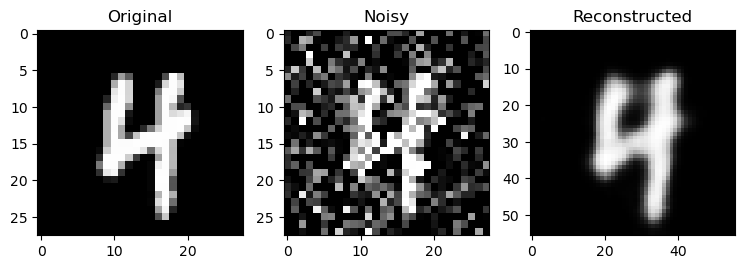

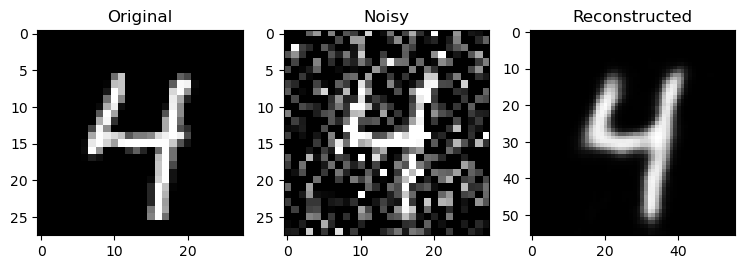

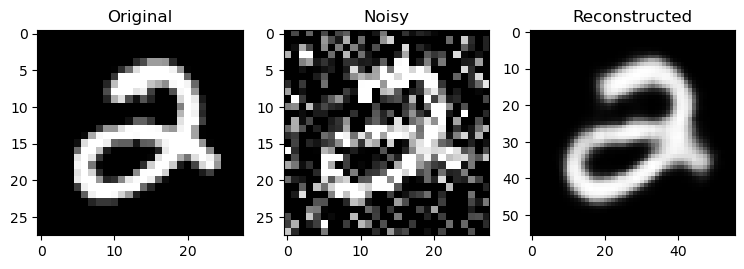

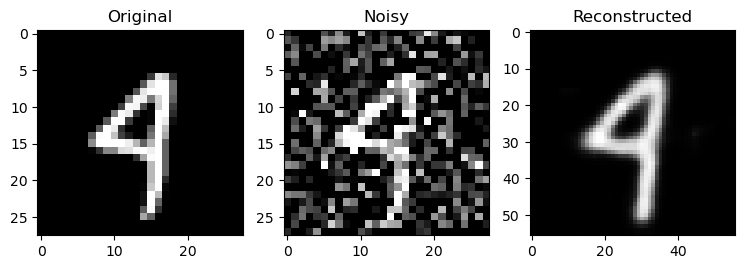

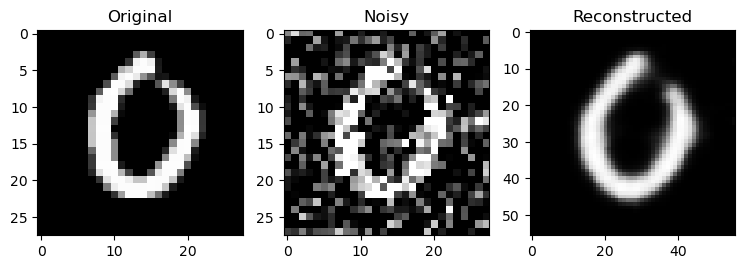

In [5]:
model.eval()

# Muestra algunas imágenes originales, ruidosas y reconstruidas
with torch.no_grad():
    for i in range(5):
        img, _ = random.choice(train_dataset)
        noisy_img = add_noise(img.unsqueeze(0)) 
        recon = model(noisy_img)

        plt.figure(figsize=(9, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title('Original')

        plt.subplot(1, 3, 2)
        plt.imshow(noisy_img.squeeze(), cmap='gray')
        plt.title('Noisy')

        plt.subplot(1, 3, 3)
        plt.imshow(recon.squeeze().detach().numpy(), cmap='gray')
        plt.title('Reconstructed')

        plt.show()
